In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import seaborn as sns

print("seaborn version:{}".format(sns.__version__))

%matplotlib inline

seaborn version:0.8.1


In [2]:
SUFFIX="cc1-fulldefrag"

FONT_SIZE = 20
plt.rcParams["font.family"] = "sans-serif"

In [3]:
def plot_thruput_ratio(thruput_data, keys, name):
    means = []
    labels = []
    
    for bench in thruput_data.keys():
        df_stw, df_conc = thruput_data[bench]
        
        sum_stw = df_stw[keys[0]].copy()
        sum_conc = df_conc[keys[0]].copy()
        for key in keys[1:]:
            sum_stw += df_stw[key]
            sum_conc += df_conc[key]
        
        time_stw = np.mean(sum_stw)
        time_conc = np.mean(sum_conc)
        means.append((time_conc / time_stw))
        
        labels.append("{}:{}".format(bench, name))
    
    n = len(labels)
    fig, ax = plt.subplots()
    fig.set_size_inches((20,12))
    
    ind = np.arange(n)
    ax.bar(ind, np.array(means)-1, bottom=0)
    
    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(FONT_SIZE)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FONT_SIZE)
#         tick.label.set_rotation(45)
    
    # small ticks
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.tick_params('y', length=15, width=2, which='major')
    ax.tick_params('y', length=10, width=1, which='minor')
    
    # set to percentage
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.2f}%'.format(y*100) for y in vals])
    
    plt.show()
    
    return fig

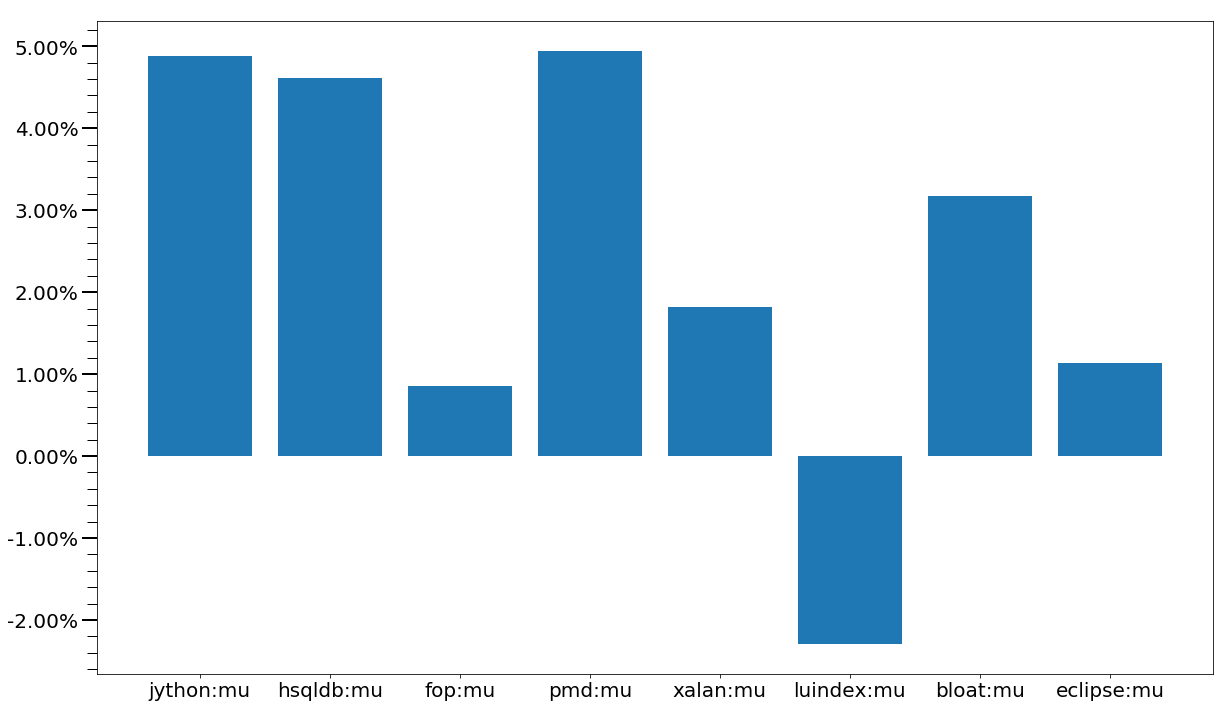

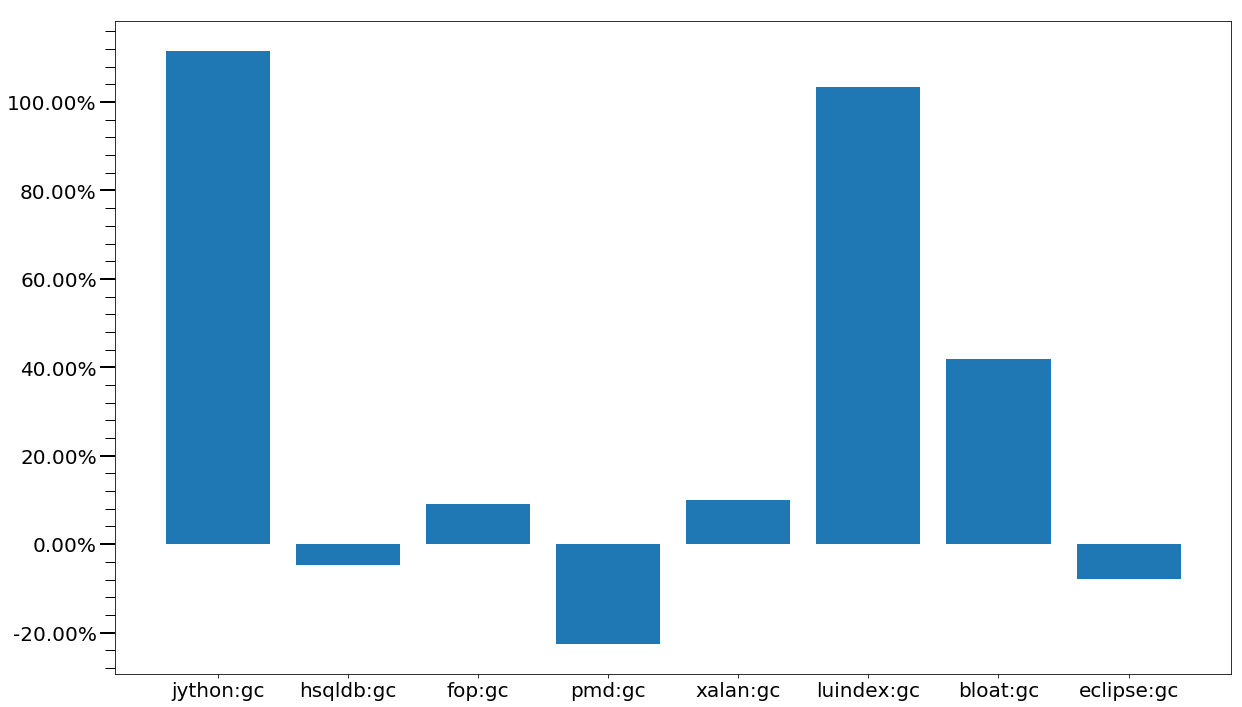

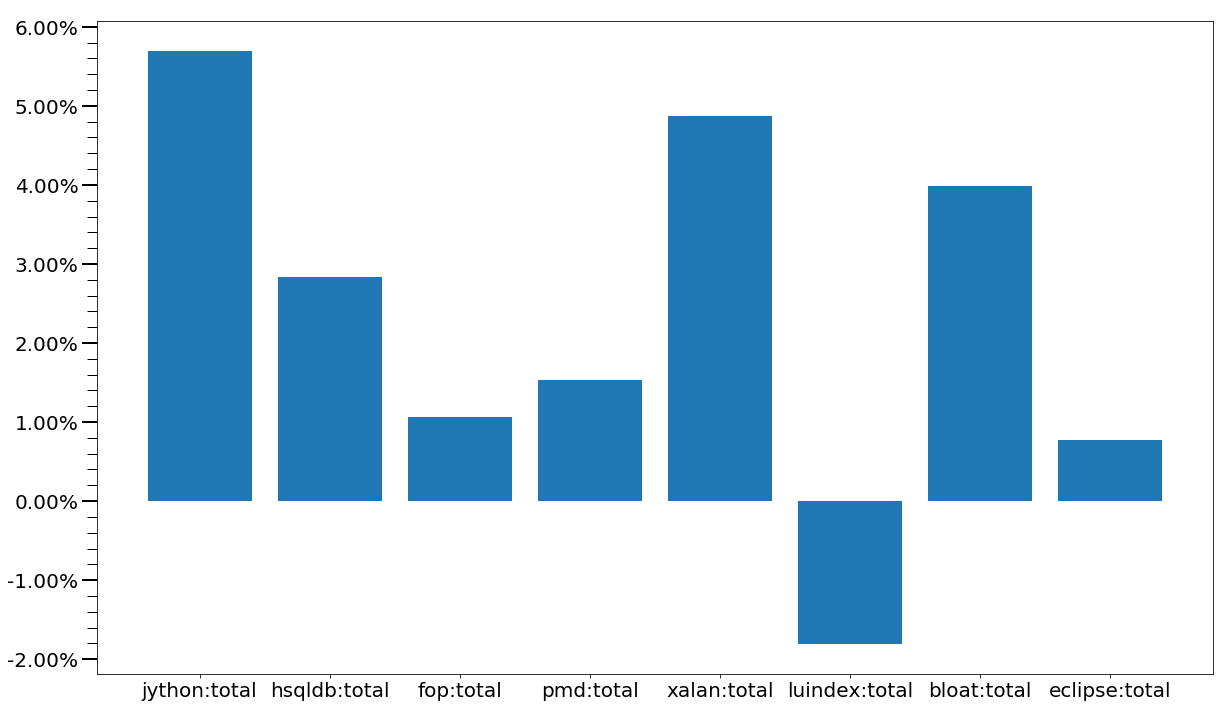

In [4]:
thruput_data = pickle.load(open('pickles/thruput-{}.pkl'.format(SUFFIX),'rb'))

fig_mu = plot_thruput_ratio(thruput_data, ["time.mu"], "mu")
fig_gc = plot_thruput_ratio(thruput_data, ["time.gc"], "gc")
fig_total = plot_thruput_ratio(thruput_data, ["time.mu", "time.gc"], "total")

fig_mu.savefig("thruput-mu.eps")
fig_gc.savefig("thruput-gc.eps")
fig_total.savefig('thruput-total.eps')

In [5]:
def filter_phases(df):
    df = df.loc[df['defrags.gc'] == 0]
    df = df.loc[(df['time.mu'] > 0.01) & (df['time.gc'] > 0.01)]
    return df

def plot_pause_boxplot(pauses, labels):
    fig, ax = plt.subplots(figsize=(20,12))
    
    bp = ax.boxplot(pauses, patch_artist=True, whis=[5,95], medianprops = dict(linewidth=2.5, color='yellow'), showfliers=False)
    plt.setp(bp['fliers'], color='red', marker='+')
    i = 0
    for patch in bp['boxes']:
        if i % 2 == 0:
            patch.set(facecolor='red')
        else:
            patch.set(facecolor='green')
        i += 1
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FONT_SIZE)
        tick.label.set_rotation(45)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(FONT_SIZE)
        
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:.0f}ms'.format(x) for x in vals])
    
    rcimmix = mpatches.Patch(color='red', label='RCImmix')
    rcimmixconcurrent = mpatches.Patch(color='green', label='RCImmixConcurrent')
    plt.legend(handles=[rcimmix, rcimmixconcurrent], fontsize=FONT_SIZE)
    
    ax.set_xticklabels(labels)
    plt.show()
    
    return fig

# https://gist.github.com/mpharrigan/a4375afa71d560dbdf3a0d96552a1cd5
class MyVPlot(sns.categorical._ViolinPlotter):
    def draw_quartiles(self, ax, data, support, density, center, split=False):
        """Draw the quartiles as lines at width of density."""
        q1, qm, q2 = np.percentile(data, [10, 50, 90])
        self.draw_to_density(ax, center, qm, support, density, split,
                             linewidth=self.linewidth)
        self.draw_to_density(ax, center, q1, support, density, split,
                             linewidth=self.linewidth)
        self.draw_to_density(ax, center, q2, support, density, split,
                             linewidth=self.linewidth)
    
    def draw_to_density(self, ax, center, val, support, density, split, **kws):
        """Draw a line orthogonal to the value axis at width of density."""
        idx = np.argmin(np.abs(support - val))
        width = self.dwidth * density[idx] * .99

        kws["color"] = "yellow"

        if self.orient == "v":
            if split == "left":
                ax.plot([center - width, center], [val, val], **kws)
            elif split == "right":
                ax.plot([center, center + width], [val, val], **kws)
            else:
                ax.plot([center - width, center + width], [val, val], **kws)
        else:
            if split == "left":
                ax.plot([val, val], [center - width, center], **kws)
            elif split == "right":
                ax.plot([val, val], [center, center + width], **kws)
            else:
                ax.plot([val, val], [center - width, center + width], **kws)

def my_violinplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
                  bw="scott", cut=2, scale="area", scale_hue=True, gridsize=100,
                  width=.8, inner="box", split=False, dodge=True, orient=None,
                  linewidth=None, color=None, palette=None, saturation=.75,
                  ax=None, **kwargs):
    plotter = MyVPlot(x, y, hue, data, order, hue_order,
                      bw, cut, scale, scale_hue, gridsize,
                      width, inner, split, dodge, orient, linewidth,
                      color, palette, saturation)
    if ax is None:
        ax = plt.gca()

    plotter.plot(ax)
    return ax
        
def plot_pause_violin(pauses, labels):
    fig, ax = plt.subplots(figsize=(22,12))
    n = len(labels)
    
    color1 = "red"
    color2 = "green"
    
    # set color
    palette = {}
    for i in range(n):
        if i % 2 == 0:
            palette[i] = color1
        else:
            palette[i] = color2
    
    # plot
    violin = my_violinplot(data=pauses, palette=palette, vert=True, width=0.8, scale="width", inner="quartile", ax=ax, cut=0)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FONT_SIZE)
#         tick.label.set_rotation(45)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(FONT_SIZE)
    
    ax.set_xticklabels(labels)
    
    rcimmix = mpatches.Patch(color=color1, label='RCImmix')
    rcimmixconcurrent = mpatches.Patch(color=color2, label='RCImmixConcurrent')
    plt.legend(handles=[rcimmix, rcimmixconcurrent], fontsize=FONT_SIZE)
    
    plt.show()
    return fig

def plot_pause(pause_data, benchs):
    pauses = []
    labels = []
    
    for bench in benchs:
        df_stw = filter_phases(pause_data[bench][0])
        df_conc = filter_phases(pause_data[bench][1])
        
        pauses.append(np.array(df_stw['time.gc']))
        pauses.append(np.array(df_conc['time.gc']))
        labels.append("{}".format(bench))
        labels.append("{}".format(bench))
    
    return plot_pause_boxplot(pauses, labels)
#     return plot_pause_violin(pauses, labels)

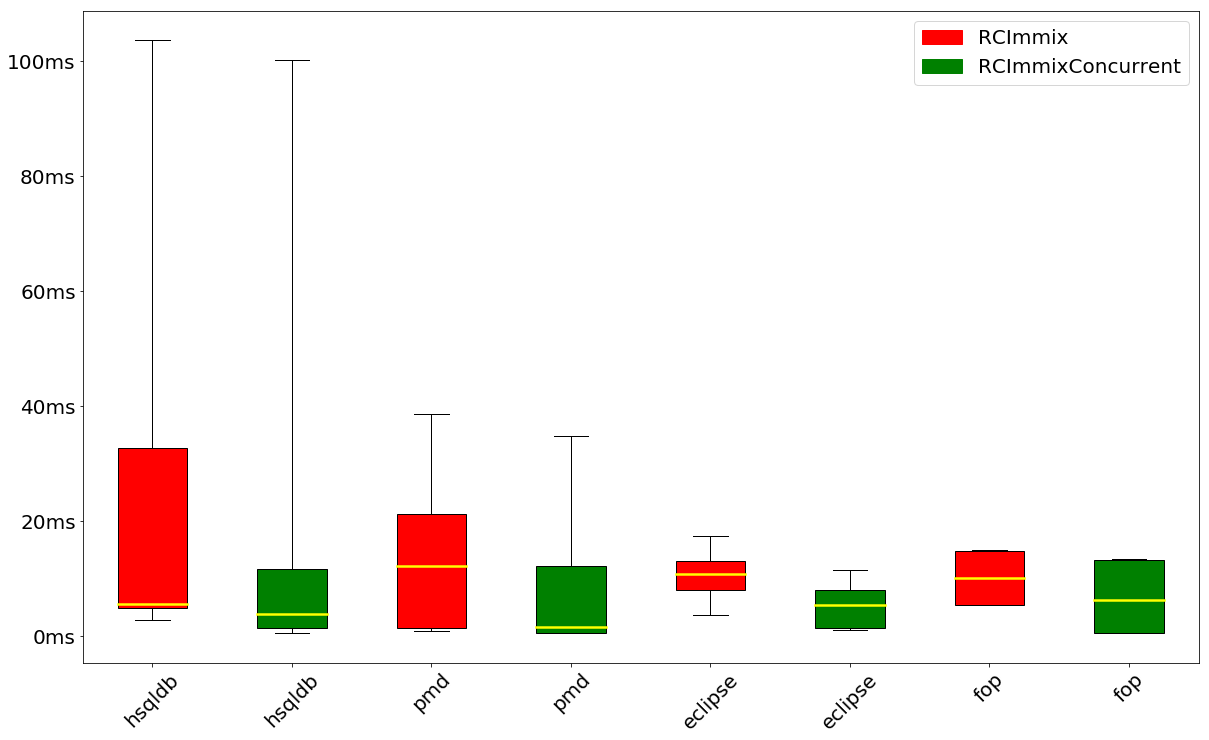

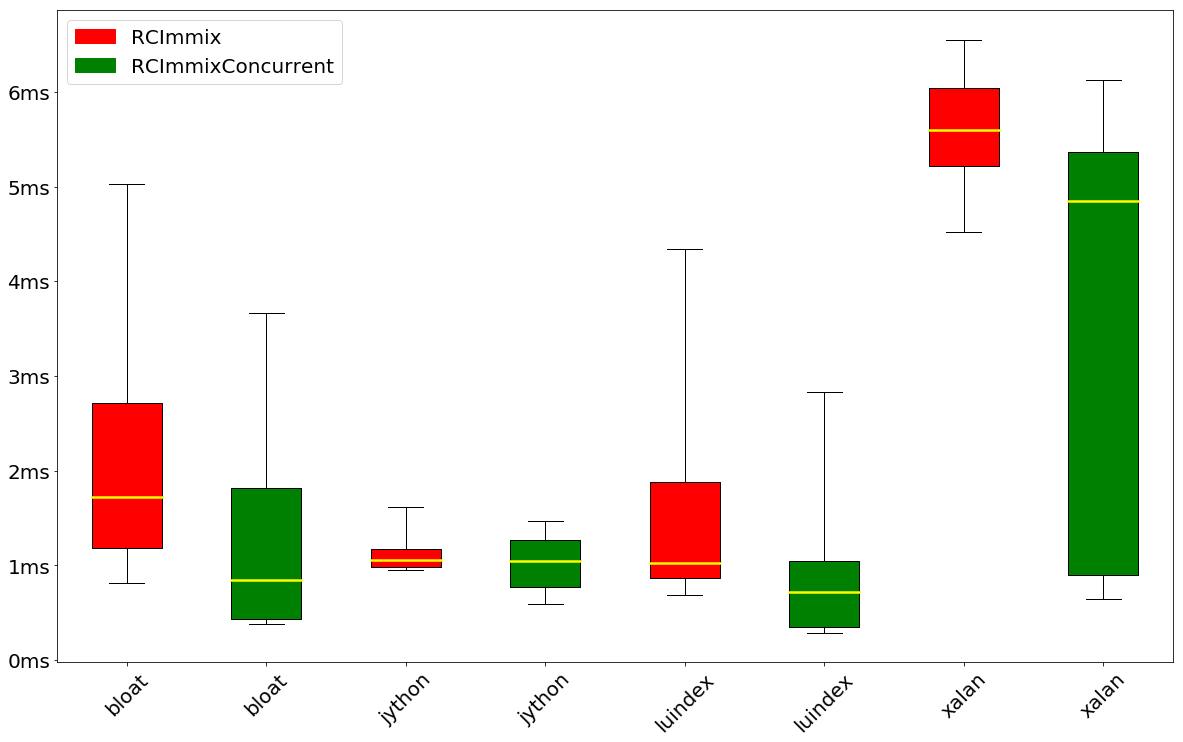

In [6]:
pause_data = pickle.load(open('pickles/pause-stress-40M-{}.pkl'.format(SUFFIX), 'rb'))
fig_big = plot_pause(pause_data, ["hsqldb", "pmd", "eclipse", "fop"])
fig_big.savefig('pause-freq-1-big.eps')
fig_small = plot_pause(pause_data, ["bloat", "jython", "luindex", "xalan"])
fig_small.savefig('pause-freq-1-small.eps')

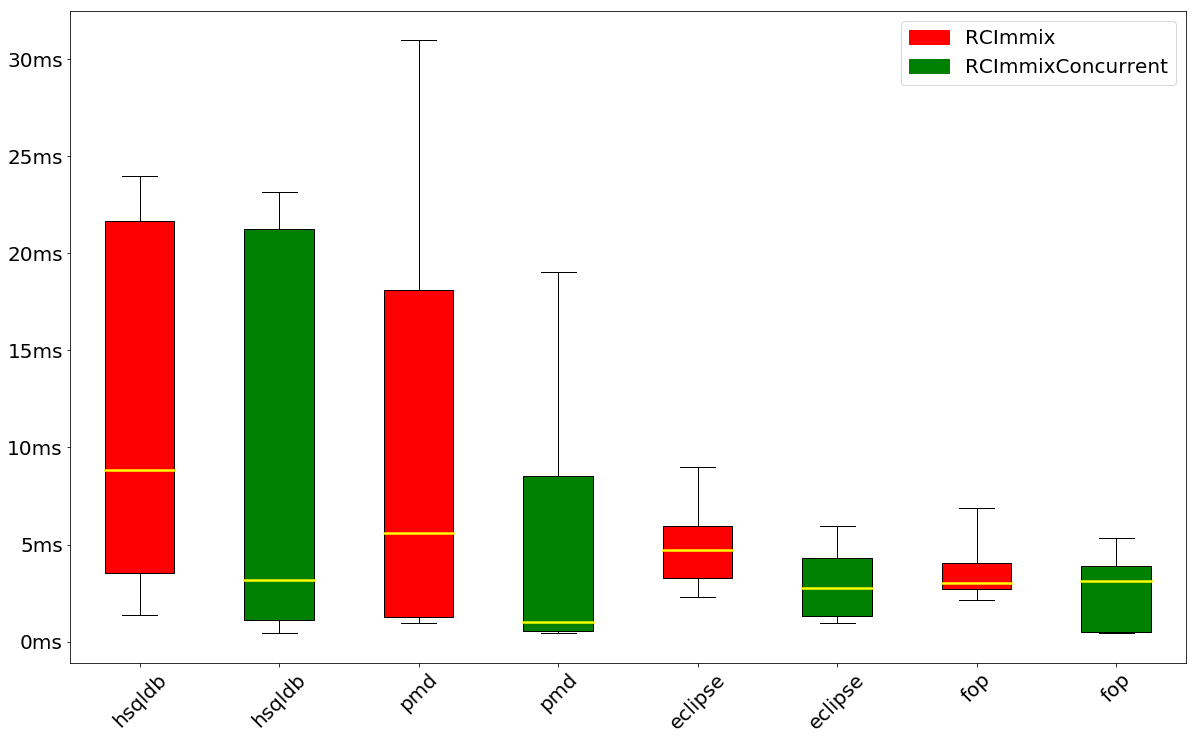

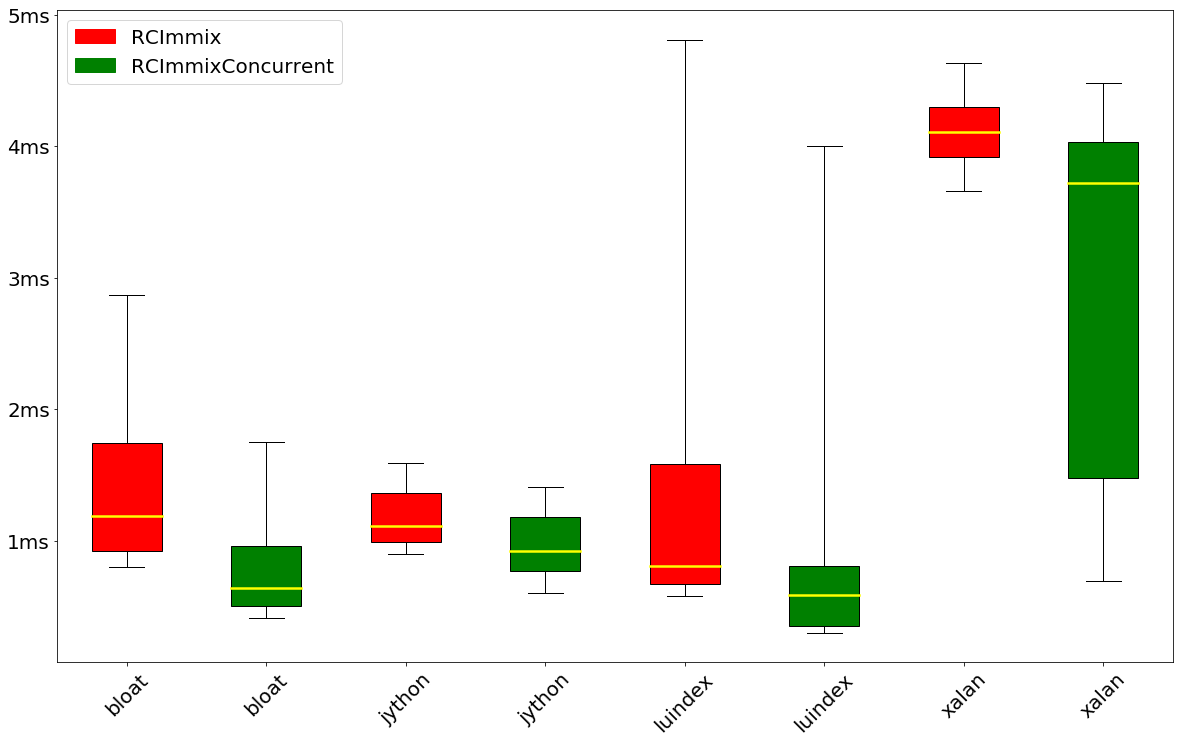

In [7]:
pause_data = pickle.load(open('pickles/pause-stress-8M-{}.pkl'.format(SUFFIX), 'rb'))
fig_big = plot_pause(pause_data, ["hsqldb", "pmd", "eclipse", "fop"])
fig_big.savefig('pause-freq-2-big.eps')
fig_small = plot_pause(pause_data, ["bloat", "jython", "luindex", "xalan"])
fig_small.savefig('pause-freq-2-small.eps')

In [16]:
def mean_confidence_interval(data, confidence=0.95):
    interval = sp.stats.t.interval(confidence, len(data)-1, loc=np.mean(data), scale=sp.stats.sem(data))
    return np.mean(data) - interval[0]

def print_table(thruput_data):
    ratio_mu = []
    ratio_gc = []
    ratio_total = []
    
    for bench in thruput_data.keys():
        df_stw, df_conc = thruput_data[bench]
        
        df_stw = df_stw[["time.mu", "time.gc"]].copy()
        df_stw["time.total"] = df_stw["time.mu"] + df_stw["time.gc"]
        time_stw_gc = np.mean(df_stw["time.gc"])
        time_stw_gc_ci = mean_confidence_interval(df_stw["time.gc"])
        time_stw_mu = np.mean(df_stw["time.mu"])
        time_stw_mu_ci = mean_confidence_interval(df_stw["time.mu"])
        time_stw_total = np.mean(df_stw["time.total"])
        time_stw_total_ci = mean_confidence_interval(df_stw["time.total"])
        
        df_conc = df_conc[["time.mu", "time.gc"]].copy()
        df_conc["time.total"] = df_conc["time.mu"] + df_conc["time.gc"]
        time_conc_gc = np.mean(df_conc["time.gc"])
        time_conc_gc_ci = mean_confidence_interval(df_conc["time.gc"])
        time_conc_mu = np.mean(df_conc["time.mu"])
        time_conc_mu_ci = mean_confidence_interval(df_conc["time.mu"])
        time_conc_total = np.mean(df_conc["time.total"])
        time_conc_total_ci = mean_confidence_interval(df_conc["time.total"])
        
        print("{} & ${:.2f} \\pm {:.2f}$ & ${:.2f} \\pm {:.2f}$ & ${:.2f} \\pm {:.2f}$"
                 "& ${:.2f} \\pm {:.2f}$ & ${:.2f} \\pm {:.2f}$ & ${:.2f} \\pm {:.2f}$ & ${:.2f}$ & ${:.2f}$ & ${:.2f}$ \\\\"
                .format(
                    bench,
                    time_stw_mu, time_stw_mu_ci, time_stw_gc, time_stw_gc_ci, time_stw_total, time_stw_total_ci,
                    time_conc_mu, time_conc_mu_ci, time_conc_gc, time_conc_gc_ci, time_conc_total, time_conc_total_ci,
                    time_conc_mu / time_stw_mu, time_conc_gc / time_stw_gc, time_conc_total / time_stw_total))
        
        ratio_mu.append(time_conc_mu / time_stw_mu)
        ratio_gc.append(time_conc_gc / time_stw_gc)
        ratio_total.append(time_conc_total / time_stw_total)
    
    from scipy.stats.mstats import gmean
    
    print("{:.2f} & {:.2f} & {:.2f}".format(gmean(ratio_mu), gmean(ratio_gc), gmean(ratio_total)))
    
print_table(thruput_data)

jython & $1881.35 \pm 6.63$ & $14.41 \pm 0.48$ & $1895.76 \pm 6.94$& $1973.19 \pm 8.10$ & $30.49 \pm 0.71$ & $2003.68 \pm 8.66$ & $1.05$ & $2.12$ & $1.06$ \\
hsqldb & $832.50 \pm 30.53$ & $197.23 \pm 8.74$ & $1029.73 \pm 33.43$& $870.90 \pm 35.17$ & $187.99 \pm 2.01$ & $1058.89 \pm 36.17$ & $1.05$ & $0.95$ & $1.03$ \\
fop & $609.09 \pm 1.93$ & $15.92 \pm 0.29$ & $625.01 \pm 1.82$& $614.33 \pm 2.09$ & $17.35 \pm 0.35$ & $631.68 \pm 2.02$ & $1.01$ & $1.09$ & $1.01$ \\
pmd & $1655.53 \pm 13.10$ & $233.51 \pm 16.17$ & $1889.05 \pm 28.81$& $1737.34 \pm 36.33$ & $180.70 \pm 8.06$ & $1918.04 \pm 41.47$ & $1.05$ & $0.77$ & $1.02$ \\
xalan & $624.65 \pm 4.47$ & $365.45 \pm 7.13$ & $990.09 \pm 8.70$& $636.03 \pm 6.56$ & $402.26 \pm 6.12$ & $1038.28 \pm 9.47$ & $1.02$ & $1.10$ & $1.05$ \\
luindex & $2487.21 \pm 6.66$ & $11.45 \pm 0.36$ & $2498.66 \pm 6.73$& $2430.14 \pm 14.22$ & $23.30 \pm 1.38$ & $2453.44 \pm 14.47$ & $0.98$ & $2.03$ & $0.98$ \\
bloat & $2513.74 \pm 32.61$ & $53.66 \pm 3.30$ & $